In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive/')

## set a folder as current working dir

os.chdir('/content/drive/My Drive/AI4T/spatial_clustering/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# spatial CLustering

In [ ]:
# Install the kneed library if not already installed
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan
import warnings
warnings.filterwarnings('ignore')

class SpatialClustering:
    """
    Class for performing spatial clustering on geolocation data
    """

    def __init__(self, df, lat_col='latitude', lon_col='longitude'):
        """
        Initialize spatial clustering with dataframe and coordinate columns

        Input:
            df: DataFrame with spatial coordinates
            lat_col: Name of latitude column
            lon_col: Name of longitude column

        Output:
            Initialized SpatialClustering object

        Task:
            Set up data and validate coordinate columns
        """
        self.df = df.copy()
        self.lat_col = lat_col
        self.lon_col = lon_col

        # Validate coordinate columns
        if lat_col not in df.columns or lon_col not in df.columns:
            raise ValueError(f"Latitude column '{lat_col}' or Longitude column '{lon_col}' not found in DataFrame")

        # Clean coordinates
        self._clean_coordinates()

        # Prepare features for clustering
        self.X = self._prepare_features()

    def _clean_coordinates(self):
        """
        Clean and validate coordinate data

        Input: None (uses self.df)
        Output: Cleaned coordinates in self.df

        Task: Remove invalid coordinates and handle missing values
        """
        # Remove rows with null coordinates
        self.df = self.df.dropna(subset=[self.lat_col, self.lon_col])

        # Validate coordinate ranges (approximate for Nepal)
        valid_mask = (
            (self.df[self.lat_col] >= 26) & (self.df[self.lat_col] <= 30) &  # Nepal latitude range
            (self.df[self.lon_col] >= 80) & (self.df[self.lon_col] <= 88)    # Nepal longitude range
        )

        if not valid_mask.all():
            invalid_count = (~valid_mask).sum()
            print(f"Removing {invalid_count} rows with coordinates outside Nepal range")
            self.df = self.df[valid_mask]

        print(f"Clean data shape: {self.df.shape}")

    def _prepare_features(self):
        """
        Prepare features for clustering

        Input: None (uses self.df)
        Output: Feature matrix X

        Task: Extract and scale coordinates for clustering
        """
        # Extract coordinates
        coordinates = self.df[[self.lat_col, self.lon_col]].values

        # Optional: Add additional features if available
        additional_features = []

        # If we have other numerical features, add them here
        # Example: if 'star_rating' in self.df.columns:
        #     additional_features.append(self.df['star_rating'].fillna(0).values)

        if additional_features:
            features = np.column_stack([coordinates] + additional_features)
        else:
            features = coordinates

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)

        return X_scaled

    # ==================== KMEANS CLUSTERING ====================

    def kmeans_clustering(self, n_clusters=None, max_clusters=10):
        """
        Perform KMeans clustering with optimal cluster number selection

        Input:
            n_clusters: Number of clusters (if None, auto-select)
            max_clusters: Maximum clusters to try for elbow method

        Output:
            Dictionary with clustering results and metrics

        Task:
            Perform KMeans clustering with optional automatic cluster selection
        """
        if n_clusters is None:
            n_clusters = self._find_optimal_k(max_clusters)

        print(f"Performing KMeans clustering with {n_clusters} clusters...")

        # Perform KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(self.X)

        # Calculate cluster centers in original coordinate space
        cluster_centers = kmeans.cluster_centers_

        # Calculate metrics
        metrics = self._calculate_clustering_metrics(self.X, labels)
        metrics['inertia'] = kmeans.inertia_

        # Get cluster statistics
        cluster_stats = self._get_cluster_statistics(labels)

        return {
            'model': kmeans,
            'labels': labels,
            'cluster_centers': cluster_centers,
            'n_clusters': n_clusters,
            'metrics': metrics,
            'cluster_stats': cluster_stats
        }

    def _find_optimal_k(self, max_clusters=10):
        """
        Find optimal number of clusters using elbow method and silhouette score

        Input:
            max_clusters: Maximum clusters to try

        Output:
            Optimal number of clusters

        Task:
            Determine best k using elbow method and silhouette scores
        """
        inertias = []
        silhouette_scores = []

        # Try different k values
        k_values = range(2, max_clusters + 1)

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.X)

            inertias.append(kmeans.inertia_)

            # Silhouette score requires at least 2 clusters and not all points in one cluster
            if len(set(labels)) > 1 and not (labels == labels[0]).all():
                silhouette_scores.append(silhouette_score(self.X, labels))
            else:
                silhouette_scores.append(0)

        # Find elbow point
        diffs = np.diff(inertias)
        diff_diffs = np.diff(diffs)
        elbow_k = np.argmax(diff_diffs) + 3  # +3 because of double diff

        # Find best silhouette score
        silhouette_k = k_values[np.argmax(silhouette_scores)]

        # Choose optimal k
        optimal_k = silhouette_k  # Prefer silhouette method

        print(f"Elbow method suggests: {elbow_k} clusters")
        print(f"Silhouette method suggests: {silhouette_k} clusters")
        print(f"Selected: {optimal_k} clusters")

        # Plot elbow curve and silhouette scores
        self._plot_k_selection(k_values, inertias, silhouette_scores, elbow_k, silhouette_k)

        return optimal_k

    def _plot_k_selection(self, k_values, inertias, silhouette_scores, elbow_k, silhouette_k):
        """
        Plot elbow curve and silhouette scores for KMeans

        Input:
            k_values: Range of k values tested
            inertias: Inertia values for each k
            silhouette_scores: Silhouette scores for each k
            elbow_k: K suggested by elbow method
            silhouette_k: K suggested by silhouette method

        Output:
            None (displays plot)

        Task:
            Visualize KMeans cluster selection metrics
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Elbow plot
        ax1.plot(k_values, inertias, 'bo-', linewidth=2)
        ax1.axvline(x=elbow_k, color='r', linestyle='--', alpha=0.5, label=f'Elbow (k={elbow_k})')
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Silhouette score plot
        ax2.plot(k_values, silhouette_scores, 'go-', linewidth=2)
        ax2.axvline(x=silhouette_k, color='r', linestyle='--', alpha=0.5, label=f'Best (k={silhouette_k})')
        ax2.set_xlabel('Number of clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Scores for Different k')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # ==================== DBSCAN CLUSTERING ====================

    def dbscan_clustering(self, eps=None, min_samples=None):
        """
        Perform DBSCAN clustering with parameter optimization

        Input:
            eps: Maximum distance between samples (if None, auto-select)
            min_samples: Minimum samples in a neighborhood (if None, auto-select)

        Output:
            Dictionary with clustering results and metrics

        Task:
            Perform DBSCAN clustering with automatic parameter tuning
        """
        if eps is None or min_samples is None:
            eps, min_samples = self._optimize_dbscan_params()

        print(f"Performing DBSCAN clustering with eps={eps:.3f}, min_samples={min_samples}...")

        # Perform DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(self.X)

        # Identify noise points
        noise_mask = labels == -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = noise_mask.sum()

        print(f"Found {n_clusters} clusters with {n_noise} noise points ({n_noise/len(labels)*100:.1f}%)")

        # Calculate metrics (excluding noise for some metrics)
        if n_clusters > 1:
            # Create mask for non-noise points
            non_noise_mask = labels != -1

            if non_noise_mask.sum() > 1:
                metrics = self._calculate_clustering_metrics(
                    self.X[non_noise_mask],
                    labels[non_noise_mask]
                )
            else:
                metrics = {'silhouette': -1, 'calinski_harabasz': -1, 'davies_bouldin': float('inf')}
        else:
            metrics = {'silhouette': -1, 'calinski_harabasz': -1, 'davies_bouldin': float('inf')}

        # Get cluster statistics
        cluster_stats = self._get_cluster_statistics(labels)

        return {
            'model': dbscan,
            'labels': labels,
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'metrics': metrics,
            'cluster_stats': cluster_stats
        }

    def _optimize_dbscan_params(self):
        """
        Optimize DBSCAN parameters using k-distance graph

        Input: None (uses self.X)
        Output: Optimized eps and min_samples values

        Task:
            Determine optimal DBSCAN parameters automatically
        """
        from sklearn.neighbors import NearestNeighbors

        # Calculate k-distances for k=min_samples
        min_samples_default = max(5, min(10, len(self.X) // 20))

        # Try to find knee point in k-distance graph
        nbrs = NearestNeighbors(n_neighbors=min_samples_default).fit(self.X)
        distances, indices = nbrs.kneighbors(self.X)

        # Sort k-distances
        k_distances = np.sort(distances[:, -1])

        # Find knee point (largest curvature)
        from kneed import KneeLocator

        try:
            kneedle = KneeLocator(
                range(len(k_distances)),
                k_distances,
                S=1.0,
                curve='convex',
                direction='increasing'
            )
            eps = kneedle.knee_y if kneedle.knee_y else np.percentile(k_distances, 75)
        except:
            # Fallback to 75th percentile
            eps = np.percentile(k_distances, 75)

        # Set min_samples based on data size
        min_samples = max(2, len(self.X) // 100)  # At least 2, or 1% of data

        print(f"Auto-selected parameters: eps={eps:.3f}, min_samples={min_samples}")

        # Plot k-distance graph
        self._plot_k_distance(k_distances, eps)

        return eps, min_samples

    def _plot_k_distance(self, k_distances, eps):
        """
        Plot k-distance graph for DBSCAN parameter selection

        Input:
            k_distances: Sorted k-distance values
            eps: Selected eps value

        Output:
            None (displays plot)

        Task:
            Visualize k-distance graph for DBSCAN parameter tuning
        """
        plt.figure(figsize=(10, 6))
        plt.plot(k_distances, linewidth=2)
        plt.axhline(y=eps, color='r', linestyle='--', label=f'eps = {eps:.3f}')
        plt.xlabel('Points sorted by distance')
        plt.ylabel(f'k-distance')
        plt.title('k-Distance Graph for DBSCAN Parameter Selection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # ==================== HDBSCAN CLUSTERING ====================

    def hdbscan_clustering(self, min_cluster_size=None, min_samples=None):
        """
        Perform HDBSCAN clustering

        Input:
            min_cluster_size: Minimum cluster size (if None, auto-select)
            min_samples: Minimum samples (if None, auto-select)

        Output:
            Dictionary with clustering results and metrics

        Task:
            Perform HDBSCAN clustering with automatic parameter tuning
        """
        # Set default parameters
        if min_cluster_size is None:
            min_cluster_size = max(5, len(self.X) // 50)  # At least 5, or 2% of data

        if min_samples is None:
            min_samples = max(2, min_cluster_size // 2)

        print(f"Performing HDBSCAN clustering with min_cluster_size={min_cluster_size}, min_samples={min_samples}...")

        # Perform HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom',
            gen_min_span_tree=True
        )

        labels = clusterer.fit_predict(self.X)

        # Identify noise points
        noise_mask = labels == -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = noise_mask.sum()

        print(f"Found {n_clusters} clusters with {n_noise} noise points ({n_noise/len(labels)*100:.1f}%)")

        # Calculate metrics (excluding noise for some metrics)
        if n_clusters > 1:
            # Create mask for non-noise points
            non_noise_mask = labels != -1

            if non_noise_mask.sum() > 1:
                metrics = self._calculate_clustering_metrics(
                    self.X[non_noise_mask],
                    labels[non_noise_mask]
                )
            else:
                metrics = {'silhouette': -1, 'calinski_harabasz': -1, 'davies_bouldin': float('inf')}
        else:
            metrics = {'silhouette': -1, 'calinski_harabasz': -1, 'davies_bouldin': float('inf')}

        # Get cluster statistics
        cluster_stats = self._get_cluster_statistics(labels)

        # Get cluster probabilities
        probabilities = clusterer.probabilities_

        return {
            'model': clusterer,
            'labels': labels,
            'probabilities': probabilities,
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'metrics': metrics,
            'cluster_stats': cluster_stats
        }

    # ==================== HELPER METHODS ====================

    def _calculate_clustering_metrics(self, X, labels):
        """
        Calculate clustering evaluation metrics

        Input:
            X: Feature matrix
            labels: Cluster labels

        Output:
            Dictionary of clustering metrics

        Task:
            Calculate silhouette, Calinski-Harabasz, and Davies-Bouldin scores
        """
        metrics = {}

        # Silhouette Score (higher is better, range: -1 to 1)
        if len(set(labels)) > 1:
            try:
                metrics['silhouette'] = silhouette_score(X, labels)
            except:
                metrics['silhouette'] = -1
        else:
            metrics['silhouette'] = -1

        # Calinski-Harabasz Score (higher is better)
        if len(set(labels)) > 1:
            try:
                metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
            except:
                metrics['calinski_harabasz'] = -1
        else:
            metrics['calinski_harabasz'] = -1

        # Davies-Bouldin Score (lower is better)
        if len(set(labels)) > 1:
            try:
                metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
            except:
                metrics['davies_bouldin'] = float('inf')
        else:
            metrics['davies_bouldin'] = float('inf')

        return metrics

    def _get_cluster_statistics(self, labels):
        """
        Calculate statistics for each cluster

        Input:
            labels: Cluster labels

        Output:
            Dictionary of cluster statistics

        Task:
            Calculate size, density, and spatial statistics for each cluster
        """
        cluster_stats = {}

        unique_labels = np.unique(labels)

        for label in unique_labels:
            if label == -1:
                continue  # Skip noise

            # Get points in this cluster
            cluster_mask = labels == label
            cluster_points = self.X[cluster_mask]

            # Basic statistics
            stats = {
                'size': cluster_mask.sum(),
                'percentage': (cluster_mask.sum() / len(labels)) * 100,

                # Spatial statistics (using original coordinates)
                'lat_mean': self.df[self.lat_col].values[cluster_mask].mean(),
                'lon_mean': self.df[self.lon_col].values[cluster_mask].mean(),
                'lat_std': self.df[self.lat_col].values[cluster_mask].std(),
                'lon_std': self.df[self.lon_col].values[cluster_mask].std(),

                # Density (points per unit area approximation)
                'density': cluster_mask.sum() / (cluster_points.std(axis=0).prod() + 1e-10)
            }

            cluster_stats[label] = stats

        return cluster_stats

    def _assign_labels_to_dataframe(self, labels, method_name):
        """
        Assign cluster labels back to original dataframe

        Input:
            labels: Cluster labels array
            method_name: Name of clustering method

        Output:
            DataFrame with cluster labels added

        Task:
            Add clustering results to original dataframe
        """
        df_labeled = self.df.copy()
        df_labeled[f'cluster_{method_name}'] = labels

        # Add is_noise column for DBSCAN/HDBSCAN
        if method_name in ['dbscan', 'hdbscan']:
            df_labeled[f'is_noise_{method_name}'] = (labels == -1)

        return df_labeled

    # ==================== VISUALIZATION METHODS ====================

    def plot_clusters(self, labels, title="Spatial Clustering Results", figsize=(12, 8)):
        """
        Visualize clustering results on a map

        Input:
            labels: Cluster labels
            title: Plot title
            figsize: Figure size

        Output:
            None (displays plot)

        Task:
            Create scatter plot of clusters with different colors
        """
        plt.figure(figsize=figsize)

        # Create colormap
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        # Create colors for each cluster
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

        # Plot each cluster
        for i, label in enumerate(unique_labels):
            if label == -1:
                # Plot noise points in black
                mask = labels == label
                plt.scatter(
                    self.df[self.lon_col].values[mask],
                    self.df[self.lat_col].values[mask],
                    c='black', marker='x', alpha=0.3, s=20,
                    label='Noise' if i == 0 else ""
                )
            else:
                # Plot cluster points
                mask = labels == label
                plt.scatter(
                    self.df[self.lon_col].values[mask],
                    self.df[self.lat_col].values[mask],
                    c=[colors[label % len(colors)]], alpha=0.7, s=50,
                    label=f'Cluster {label}' if label < 10 else ""
                )

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_cluster_comparison(self, results_dict, figsize=(15, 10)):
        """
        Compare clustering results from different methods

        Input:
            results_dict: Dictionary of clustering results
            figsize: Figure size

        Output:
            None (displays plot)

        Task:
            Create comparison plot of different clustering methods
        """
        n_methods = len(results_dict)
        fig, axes = plt.subplots(1, n_methods, figsize=figsize)

        if n_methods == 1:
            axes = [axes]

        for idx, (method_name, result) in enumerate(results_dict.items()):
            labels = result['labels']
            ax = axes[idx]

            # Create colormap
            unique_labels = np.unique(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            colors = plt.cm.tab20(np.linspace(0, 1, max(1, n_clusters)))

            # Plot each cluster
            for i, label in enumerate(unique_labels):
                if label == -1:
                    # Plot noise points
                    mask = labels == label
                    ax.scatter(
                        self.df[self.lon_col].values[mask],
                        self.df[self.lat_col].values[mask],
                        c='black', marker='x', alpha=0.3, s=10
                    )
                else:
                    # Plot cluster points
                    mask = labels == label
                    ax.scatter(
                        self.df[self.lon_col].values[mask],
                        self.df[self.lat_col].values[mask],
                        c=[colors[label % len(colors)]], alpha=0.7, s=30
                    )

            # Add metrics to title
            metrics_text = ""
            if 'metrics' in result and result['metrics']['silhouette'] != -1:
                metrics_text = f"\nSilhouette: {result['metrics']['silhouette']:.3f}"

            ax.set_xlabel('Longitude')
            if idx == 0:
                ax.set_ylabel('Latitude')
            ax.set_title(f'{method_name.upper()}\nClusters: {n_clusters}{metrics_text}')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_metrics_comparison(self, results_dict, figsize=(12, 6)):
        """
        Compare clustering metrics across different methods

        Input:
            results_dict: Dictionary of clustering results
            figsize: Figure size

        Output:
            None (displays plot)

        Task:
            Create bar chart comparing clustering metrics
        """
        methods = list(results_dict.keys())

        # Extract metrics
        silhouette_scores = []
        n_clusters_list = []

        for method in methods:
            result = results_dict[method]
            if 'metrics' in result and result['metrics']['silhouette'] != -1:
                silhouette_scores.append(result['metrics']['silhouette'])
            else:
                silhouette_scores.append(0)

            if 'n_clusters' in result:
                n_clusters_list.append(result['n_clusters'])
            else:
                n_clusters_list.append(len(np.unique(result['labels'])) - (1 if -1 in result['labels'] else 0))

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Silhouette scores
        bars1 = ax1.bar(methods, silhouette_scores, color=['blue', 'green', 'orange'])
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Score Comparison')
        ax1.set_ylim([min(0, min(silhouette_scores) - 0.1), max(silhouette_scores) + 0.1])
        ax1.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

        # Number of clusters
        bars2 = ax2.bar(methods, n_clusters_list, color=['blue', 'green', 'orange'])
        ax2.set_ylabel('Number of Clusters')
        ax2.set_title('Number of Clusters Comparison')
        ax2.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    # ==================== MAIN ANALYSIS METHOD ====================

    def perform_complete_analysis(self, kmeans_k=None, dbscan_params=None, hdbscan_params=None):
        """
        Perform complete spatial clustering analysis with all methods

        Input:
            kmeans_k: Number of clusters for KMeans (None for auto)
            dbscan_params: Tuple of (eps, min_samples) for DBSCAN
            hdbscan_params: Tuple of (min_cluster_size, min_samples) for HDBSCAN

        Output:
            Dictionary containing all clustering results and labeled dataframes

        Task:
            Run all clustering methods and return comprehensive results
        """
        print("=" * 60)
        print("SPATIAL CLUSTERING ANALYSIS")
        print("=" * 60)
        print(f"Number of points: {len(self.df)}")
        print()

        results = {}
        df_results = {}

        # 1. KMeans Clustering
        print("1. KMEANS CLUSTERING")
        print("-" * 40)
        if kmeans_k is not None:
            kmeans_result = self.kmeans_clustering(n_clusters=kmeans_k)
        else:
            kmeans_result = self.kmeans_clustering()

        results['kmeans'] = kmeans_result
        df_results['kmeans'] = self._assign_labels_to_dataframe(
            kmeans_result['labels'], 'kmeans'
        )

        print(f"   Clusters: {kmeans_result['n_clusters']}")
        print(f"   Silhouette: {kmeans_result['metrics']['silhouette']:.3f}")
        print()

        # 2. DBSCAN Clustering
        print("2. DBSCAN CLUSTERING")
        print("-" * 40)
        if dbscan_params is not None:
            eps, min_samples = dbscan_params
            dbscan_result = self.dbscan_clustering(eps=eps, min_samples=min_samples)
        else:
            dbscan_result = self.dbscan_clustering()

        results['dbscan'] = dbscan_result
        df_results['dbscan'] = self._assign_labels_to_dataframe(
            dbscan_result['labels'], 'dbscan'
        )

        print(f"   Clusters: {dbscan_result['n_clusters']}")
        print(f"   Noise points: {dbscan_result['n_noise']} ({dbscan_result['n_noise']/len(self.df)*100:.1f}%)")
        print(f"   Silhouette: {dbscan_result['metrics']['silhouette']:.3f}")
        print()

        # 3. HDBSCAN Clustering
        print("3. HDBSCAN CLUSTERING")
        print("-" * 40)
        if hdbscan_params is not None:
            min_cluster_size, min_samples = hdbscan_params
            hdbscan_result = self.hdbscan_clustering(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples
            )
        else:
            hdbscan_result = self.hdbscan_clustering()

        results['hdbscan'] = hdbscan_result
        df_results['hdbscan'] = self._assign_labels_to_dataframe(
            hdbscan_result['labels'], 'hdbscan'
        )

        print(f"   Clusters: {hdbscan_result['n_clusters']}")
        print(f"   Noise points: {hdbscan_result['n_noise']} ({hdbscan_result['n_noise']/len(self.df)*100:.1f}%)")
        print(f"   Silhouette: {hdbscan_result['metrics']['silhouette']:.3f}")
        print()

        # 4. Visualization
        print("4. VISUALIZATION")
        print("-" * 40)

        # Plot comparison
        self.plot_cluster_comparison(results)

        # Plot metrics comparison
        self.plot_metrics_comparison(results)

        # Plot individual clusters
        for method_name, result in results.items():
            self.plot_clusters(
                result['labels'],
                title=f"{method_name.upper()} Clustering Results"
            )

        # 5. Summary
        print("5. SUMMARY")
        print("-" * 40)
        self._print_analysis_summary(results)

        return {
            'results': results,
            'dataframes': df_results,
            'combined_df': self._create_combined_dataframe(df_results)
        }

    def _create_combined_dataframe(self, df_results):
        """
        Create a combined dataframe with all clustering results

        Input:
            df_results: Dictionary of labeled dataframes

        Output:
            Combined DataFrame with all cluster assignments

        Task:
            Merge all clustering results into a single dataframe
        """
        combined_df = self.df.copy()

        for method_name, df_method in df_results.items():
            # Add cluster labels
            combined_df[f'cluster_{method_name}'] = df_method[f'cluster_{method_name}']

            # Add noise indicator for density-based methods
            if f'is_noise_{method_name}' in df_method.columns:
                combined_df[f'is_noise_{method_name}'] = df_method[f'is_noise_{method_name}']

        return combined_df

    def _print_analysis_summary(self, results):
        """
        Print summary of clustering analysis

        Input:
            results: Dictionary of clustering results

        Output:
            None (prints summary to console)

        Task:
            Print formatted summary of clustering results
        """
        print("\nCLUSTERING ANALYSIS SUMMARY")
        print("=" * 60)

        summary_data = []
        for method_name, result in results.items():
            n_clusters = result.get('n_clusters', len(np.unique(result['labels'])) - (1 if -1 in result['labels'] else 0))
            n_noise = result.get('n_noise', (result['labels'] == -1).sum())
            silhouette = result['metrics']['silhouette'] if 'metrics' in result else -1

            summary_data.append({
                'Method': method_name.upper(),
                'Clusters': n_clusters,
                'Noise %': f"{n_noise/len(result['labels'])*100:.1f}%",
                'Silhouette': f"{silhouette:.3f}",
                'Points': len(result['labels'])
            })

        # Create and print summary table
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Print recommendations
        print("\nRECOMMENDATIONS:")
        print("-" * 40)

        # Find best method by silhouette score
        best_method = None
        best_score = -1

        for method_name, result in results.items():
            if 'metrics' in result and result['metrics']['silhouette'] > best_score:
                best_score = result['metrics']['silhouette']
                best_method = method_name

        if best_method and best_score > 0:
            print(f" Best performing method: {best_method.upper()} (Silhouette: {best_score:.3f})")

            if best_method == 'kmeans':
                print("  - Use when we know or can estimate the number of clusters")
                print("  - Good for evenly sized, spherical clusters")
            elif best_method == 'dbscan':
                print("  - Use when clusters have varying densities")
                print("  - Good for identifying noise/outliers")
            elif best_method == 'hdbscan':
                print("  - Use when clusters have varying densities and shapes")
                print("  - Good for hierarchical cluster structure")
        else:
            print("⚠ No method achieved positive silhouette score")
            print("  Consider: Checking data quality, adjusting parameters, or different preprocessing")




#  MAIN EXECUTION


In [ ]:
df_restaurants = pd.read_csv('lakeside_ONLY_restaurant.csv')

# Initialize clustering
cluster_analysis = SpatialClustering(
        df=df_restaurants,
        lat_col='latitude',
        lon_col='longitude'
    )

Clean data shape: (293, 27)


SPATIAL CLUSTERING ANALYSIS
Number of points: 293

1. KMEANS CLUSTERING
----------------------------------------
Performing KMeans clustering with 5 clusters...
   Clusters: 5
   Silhouette: 0.445

2. DBSCAN CLUSTERING
----------------------------------------
Performing DBSCAN clustering with eps=0.020, min_samples=5...
Found 0 clusters with 293 noise points (100.0%)
   Clusters: 0
   Noise points: 293 (100.0%)
   Silhouette: -1.000

3. HDBSCAN CLUSTERING
----------------------------------------
Performing HDBSCAN clustering with min_cluster_size=10, min_samples=5...
Found 3 clusters with 14 noise points (4.8%)
   Clusters: 3
   Noise points: 14 (4.8%)
   Silhouette: 0.479

4. VISUALIZATION
----------------------------------------


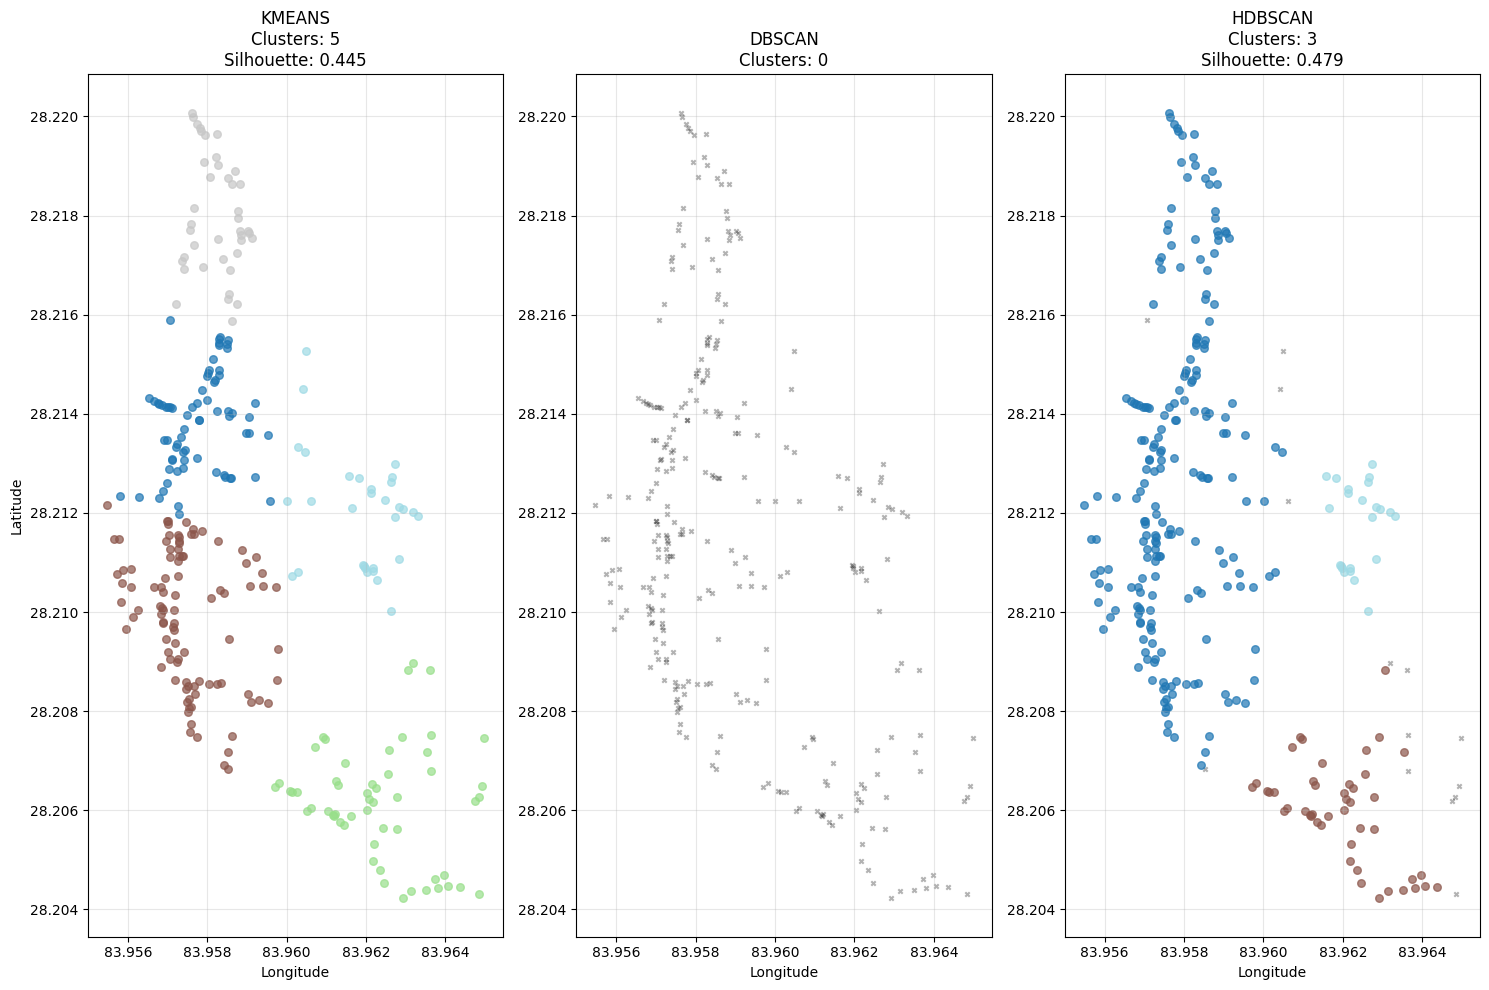

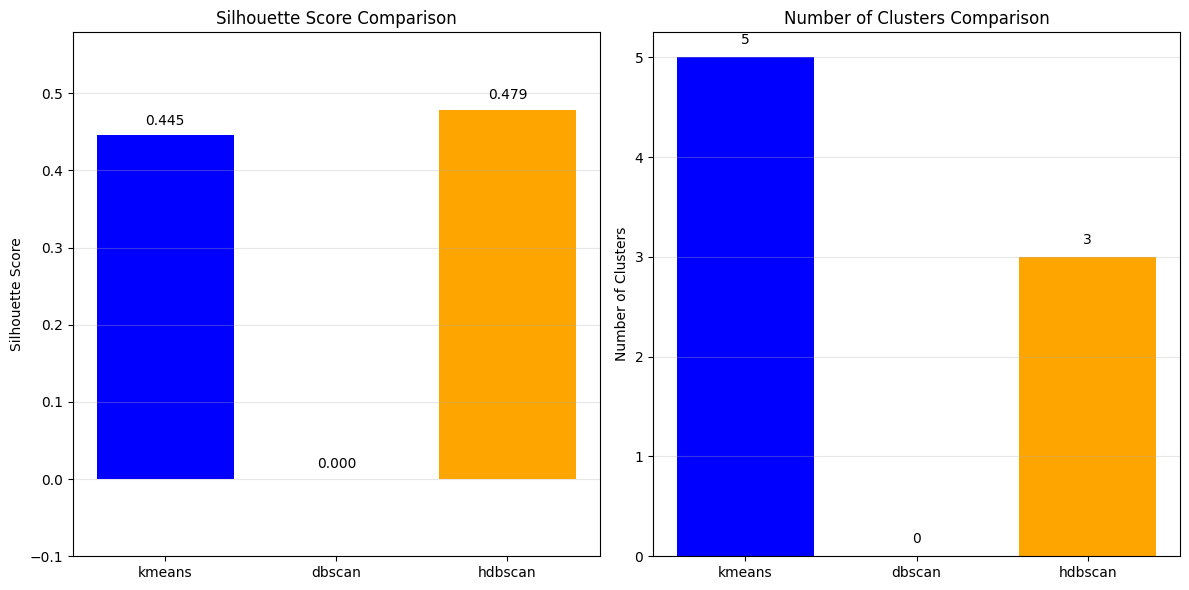

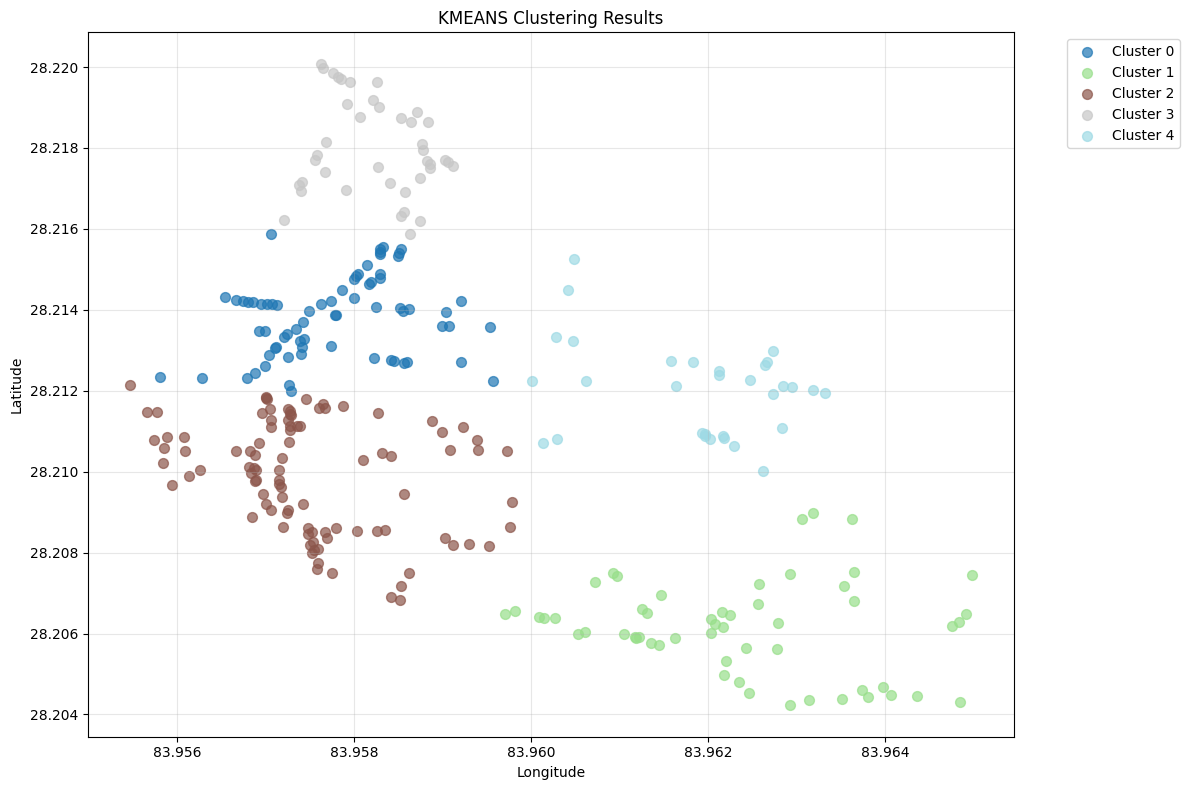

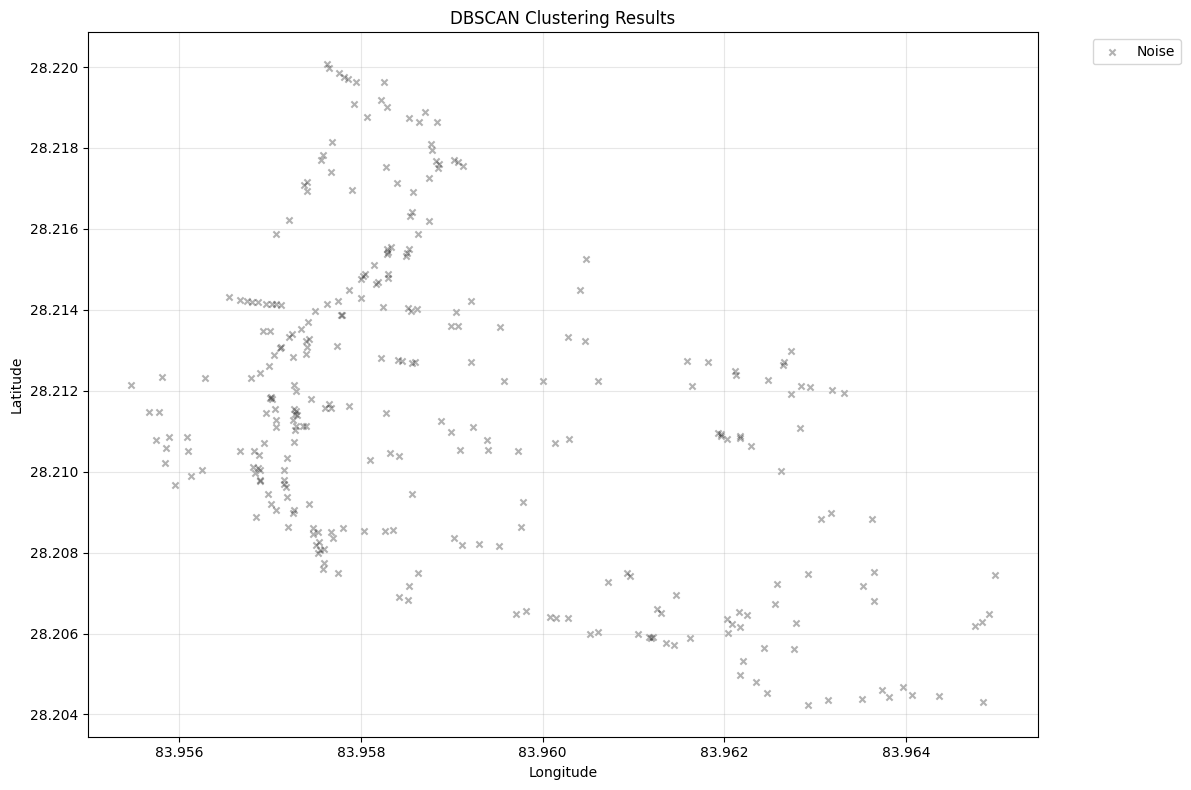

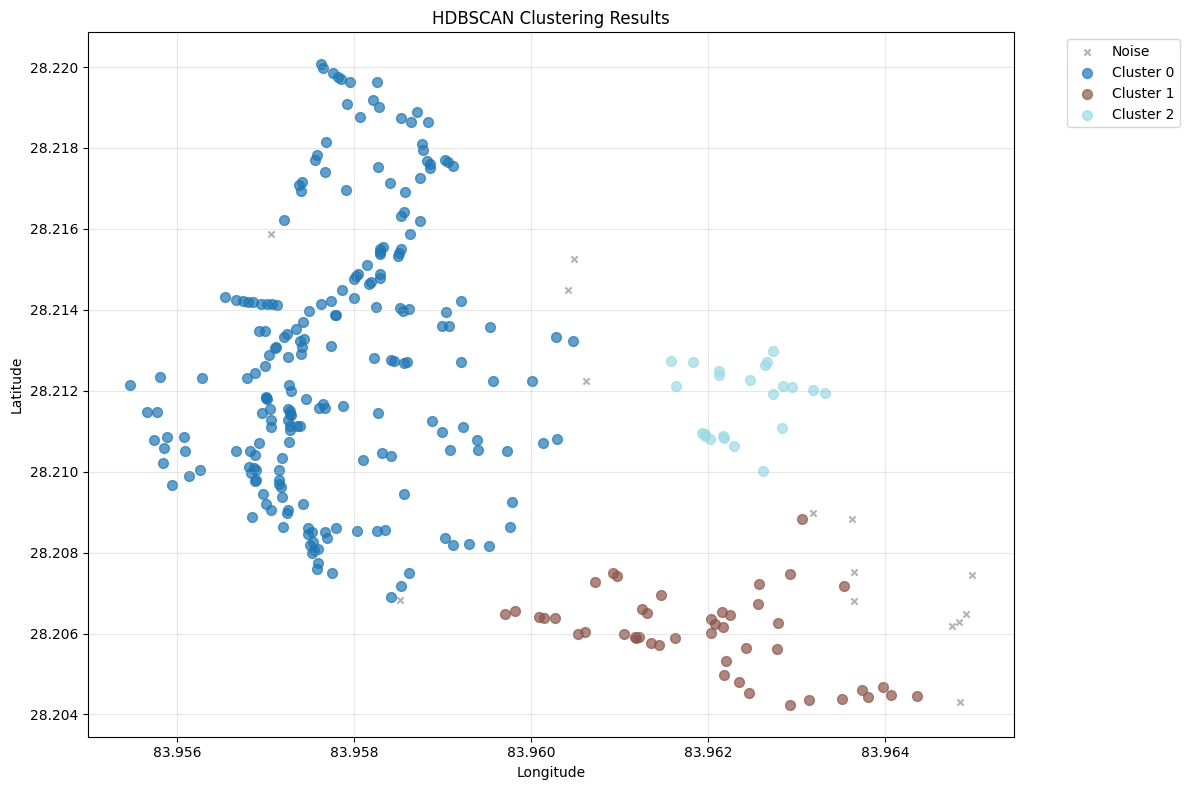

5. SUMMARY
----------------------------------------

CLUSTERING ANALYSIS SUMMARY
 Method  Clusters Noise % Silhouette  Points
 KMEANS         5    0.0%      0.445     293
 DBSCAN         0  100.0%     -1.000     293
HDBSCAN         3    4.8%      0.479     293

RECOMMENDATIONS:
----------------------------------------
✓ Best performing method: HDBSCAN (Silhouette: 0.479)
  - Use when clusters have varying densities and shapes
  - Good for hierarchical cluster structure


In [ ]:
# Run analysis with custom parameters
results = cluster_analysis.perform_complete_analysis(
        kmeans_k=5,  # Force 5 clusters for KMeans
        dbscan_params=(0.02, 5),  # Custom DBSCAN parameters
        hdbscan_params=(10, 5)  # Custom HDBSCAN parameters
    )

# Save results
results['combined_df'].to_csv('restaurants_clustered.csv', index=False)

General thresholds are often used to evaluate the average silhouette score across an entire dataset:
- > 0.70: Strong structure found.
- 0.51 – 0.70: Reasonable structure found.
- 0.26 – 0.50: Weak structure; may be artificial.
- ≤ 0.25: No substantial structure found.

## Silhouette Score Interpretation

- **Close to +1**:
  - The point is far from neighboring clusters and well-matched to its own.
  - Strong Clustering: High cohesion and high separation.
- **Around 0**:
  - The point is on or very close to the decision boundary between two clusters.
  - Overlapping Clusters: The algorithm is uncertain about the assignment.
- **Negative (-1)**:
  - The point is closer to a neighboring cluster than its assigned one.
  - Misclassification: The point has likely been assigned to the wrong cluster.